In [6]:
import os
import numpy as np
import pandas as pd

def align_sequences(X, y):
    if X.shape[0] > y.shape[0]:
        X = X[:y.shape[0], :]
    elif y.shape[0] > X.shape[0]:
        delta = y.shape[0] - X.shape[0]
        cut_start = delta // 2
        cut_end = delta - cut_start
        y = y[cut_start: -cut_end if cut_end > 0 else None, :]
    return X, y

def load_trial_data(imu_trial_folder, angles_file, window_size):
    imu_dfs = []

    # Load and show each IMU CSV as DataFrame
    for fname in sorted(os.listdir(imu_trial_folder)):
        if fname.endswith(".csv"):
            path = os.path.join(imu_trial_folder, fname)
            df = pd.read_csv(path)

            print(f"\n--- Raw IMU File: {fname} ---")
            print(df)

            # Drop timestamp
            df = df.drop(columns=[df.columns[0]])
            imu_dfs.append(df)

    if not imu_dfs:
        raise RuntimeError(f"No IMU files found in {imu_trial_folder}")

    # Optional: if you want to align lengths here
    # min_len = min(df.shape[0] for df in imu_dfs)
    # imu_dfs = [df.iloc[:min_len, :] for df in imu_dfs]

    # Make sure all lengths match before concatenation
    lengths = [df.shape[0] for df in imu_dfs]
    if len(set(lengths)) > 1:
        raise ValueError(f"IMU files in {imu_trial_folder} have different lengths: {lengths}")

    imu_concat_df = pd.concat(imu_dfs, axis=1)

    print(f"\n=== Concatenated IMU Data (Trial: {os.path.basename(imu_trial_folder)}) ===")
    print(imu_concat_df)
    print(f"Shape: {imu_concat_df.shape}")

    X = imu_concat_df.values

    # Load and clean angles
    y_df = pd.read_csv(angles_file)
    print(f"\n--- Angle File: {os.path.basename(angles_file)} ---")
    print(y_df)

    y = y_df.drop(columns=[col for col in y_df.columns if 'time' in col.lower()]).values

    X, y = align_sequences(X, y)
    plt.plot(y[:500])  # Check if this looks smooth or noisy


    X_seq, y_seq = [], []
    for i in range(len(X) - window_size + 1):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size - 1])

    return np.array(X_seq), np.array(y_seq)


In [7]:
import importlib.util

torch_spec = importlib.util.find_spec("torch")
print(torch_spec)

ModuleSpec(name='torch', loader=<_frozen_importlib_external.SourceFileLoader object at 0x11f982fb0>, origin='/Users/whiskymisky/opt/anaconda3/envs/masters/lib/python3.10/site-packages/torch/__init__.py', submodule_search_locations=['/Users/whiskymisky/opt/anaconda3/envs/masters/lib/python3.10/site-packages/torch'])



--- Processing trial_1 ---

--- Raw IMU File: 1B46F1B4-A2D2-6E21-BF55-2981B4B35216.csv ---
         Timestamp  AccelX  AccelY  AccelZ  GyroX  GyroY  GyroZ
0     1.743385e+09  -0.175  -0.186   0.987  -9.52   1.26  10.22
1     1.743385e+09  -0.183  -0.220   0.978  -3.08   0.56   6.72
2     1.743385e+09  -0.157  -0.192   0.971  -0.07  -0.35   3.57
3     1.743385e+09  -0.195  -0.195   0.965  -5.67  -1.40   0.56
4     1.743385e+09  -0.165  -0.220   0.991  -9.59  -2.52  -1.40
...            ...     ...     ...     ...    ...    ...    ...
4906  1.743385e+09   1.059  -0.289   0.231 -94.71  25.62   0.42
4907  1.743385e+09   1.034  -0.212   0.221 -34.09  13.30   3.99
4908  1.743385e+09   0.968  -0.129   0.198  -8.26   7.28   3.78
4909  1.743385e+09   0.952  -0.122   0.197   5.81   1.54   2.80
4910  1.743385e+09   0.975  -0.109   0.237  17.43  -3.50   0.49

[4911 rows x 7 columns]

--- Raw IMU File: C22972B9-EA89-C4CD-E9F5-6369FB2653E6.csv ---
         Timestamp  AccelX  AccelY  AccelZ  GyroX  

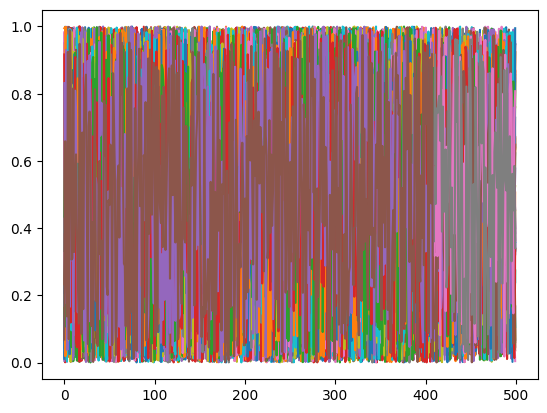

In [8]:
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt

class IMUMultiTrialDataset(Dataset):
    def __init__(self, imu_data_root, angles_dir, trial_ids, window_size):
        self.X, self.y = [], []
        for trial_id in trial_ids:
            try:
                trial_name = f"trial_{trial_id}"
                print(f"\n--- Processing {trial_name} ---")
                imu_trial_folder = os.path.join(imu_data_root, trial_name)
                angles_file = os.path.join(angles_dir, f"{trial_name}.csv")
                X_seq, y_seq = load_trial_data(imu_trial_folder, angles_file, window_size)
                self.X.append(X_seq)
                self.y.append(y_seq)
            except Exception as e:
                print(f"Skipping {trial_name}: {e}")

        self.X = np.concatenate(self.X)
        self.y = np.concatenate(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.float32)
        )

imu_data_root = os.path.abspath("dataset/imu_data")
angles_dir = os.path.abspath("dataset/angles_data/csv_files")
window_size = 50

# Define splits by trial ID
train_ids = [1, 2]
val_ids   = [3]
test_ids  = [4]

train_dataset = IMUMultiTrialDataset(imu_data_root, angles_dir, train_ids, window_size)
val_dataset   = IMUMultiTrialDataset(imu_data_root, angles_dir, val_ids, window_size)
test_dataset  = IMUMultiTrialDataset(imu_data_root, angles_dir, test_ids, window_size)

# Sanity check
x0, y0 = train_dataset[0]
print("Sample input shape:", x0.shape)
print("Sample target shape:", y0.shape)

In [9]:
import torch.nn as nn

class IMULSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use last time step
        return self.fc(out)


In [16]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn

# --- Optional: R² helper function ---
def r2_score(pred, target):
    target_mean = torch.mean(target, dim=0)
    ss_total = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - pred) ** 2)
    return 1 - (ss_res / ss_total)

# Hyperparameters
hidden_size = 128
num_layers = 2
batch_size = 32
epochs = 20
learning_rate = 1e-3

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model and optimizer
input_size = train_dataset[0][0].shape[1]
output_size = train_dataset[0][1].shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = IMULSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
mse_loss_fn = nn.MSELoss()
mae_loss_fn = nn.L1Loss()

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss_mse = 0
    train_loss_mae = 0
    train_r2_total = 0
    train_samples = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        pred = model(X_batch)
        loss_mse = mse_loss_fn(pred, y_batch)
        loss_mae = mae_loss_fn(pred, y_batch)

        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()

        train_loss_mse += loss_mse.item() * X_batch.size(0)
        train_loss_mae += loss_mae.item() * X_batch.size(0)
        train_r2_total += r2_score(pred, y_batch).item() * X_batch.size(0)
        train_samples += X_batch.size(0)

    avg_train_mse = train_loss_mse / train_samples
    avg_train_mae = train_loss_mae / train_samples
    avg_train_rmse = avg_train_mse ** 0.5
    avg_train_r2 = train_r2_total / train_samples

    # Validation
    model.eval()
    val_loss_mse = 0
    val_loss_mae = 0
    val_r2_total = 0
    val_samples = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            pred = model(X_val)

            loss_mse = mse_loss_fn(pred, y_val)
            loss_mae = mae_loss_fn(pred, y_val)

            val_loss_mse += loss_mse.item() * X_val.size(0)
            val_loss_mae += loss_mae.item() * X_val.size(0)
            val_r2_total += r2_score(pred, y_val).item() * X_val.size(0)
            val_samples += X_val.size(0)

    avg_val_mse = val_loss_mse / val_samples
    avg_val_mae = val_loss_mae / val_samples
    avg_val_rmse = avg_val_mse ** 0.5
    avg_val_r2 = val_r2_total / val_samples

    print(f"Epoch {epoch+1}")
    print(f"  Train → MSE: {avg_train_mse:.4f}, MAE: {avg_train_mae:.4f}, RMSE: {avg_train_rmse:.4f}, R²: {avg_train_r2:.4f}")
    print(f"  Val   → MSE: {avg_val_mse:.4f}, MAE: {avg_val_mae:.4f}, RMSE: {avg_val_rmse:.4f}, R²: {avg_val_r2:.4f}")
    print("-" * 70)


Epoch 1
  Train → MSE: 0.0928, MAE: 0.2595, RMSE: 0.3047, R²: -0.1499
  Val   → MSE: 0.0852, MAE: 0.2526, RMSE: 0.2919, R²: -0.0469
----------------------------------------------------------------------
Epoch 2
  Train → MSE: 0.0839, MAE: 0.2503, RMSE: 0.2896, R²: -0.0399
  Val   → MSE: 0.0854, MAE: 0.2531, RMSE: 0.2922, R²: -0.0486
----------------------------------------------------------------------
Epoch 3
  Train → MSE: 0.0834, MAE: 0.2497, RMSE: 0.2889, R²: -0.0331
  Val   → MSE: 0.0856, MAE: 0.2529, RMSE: 0.2925, R²: -0.0511
----------------------------------------------------------------------
Epoch 4
  Train → MSE: 0.0831, MAE: 0.2492, RMSE: 0.2884, R²: -0.0292
  Val   → MSE: 0.0859, MAE: 0.2534, RMSE: 0.2930, R²: -0.0549
----------------------------------------------------------------------
Epoch 5
  Train → MSE: 0.0829, MAE: 0.2487, RMSE: 0.2879, R²: -0.0261
  Val   → MSE: 0.0861, MAE: 0.2536, RMSE: 0.2935, R²: -0.0580
--------------------------------------------------------

In [11]:
print("Train y mean/std:", train_dataset.y.mean(), train_dataset.y.std())
print("Val   y mean/std:", val_dataset.y.mean(), val_dataset.y.std())
print("Train y min/max:", train_dataset.y.min(), train_dataset.y.max())
print("Val   y min/max:", val_dataset.y.min(), val_dataset.y.max())


Train y mean/std: 0.4998142714761664 0.2887276433689646
Val   y mean/std: 0.5036617080065692 0.29030902719752116
Train y min/max: 1.0173837371341143e-05 0.9999988651035612
Val   y min/max: 0.0002652978478441 0.9998641056878896


In [12]:
torch.save(model.state_dict(), "imu_lstm_weights.pth")


In [13]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        pred = model(X_test)
        test_loss += criterion(pred, y_test).item()

print(f"Test Loss: {test_loss:.4f}")


Test Loss: 1.1520
